<a href="https://colab.research.google.com/github/elka97/GBMegafon/blob/main/MegafonServiceBuyPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### Constants

In [3]:
DATA_PATH = "/gdrive/My Drive/Megafon/"
# DATA_PATH = "" 
training_dir = f"{DATA_PATH}/catboost_info/" 
DATA_PATH

'/gdrive/My Drive/Megafon/'

### Imports

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import sklearn
from sklearn.utils import class_weight

### Load methods

In [5]:
!pip install dask[dataframe]
from dask import dataframe as dd

     |████████████████████████████████| 133 kB 5.1 MB/s 


In [6]:
def load_file(fname:str): 
    _d = pd.read_csv(f'{fname}.csv', low_memory=True)
    print(f"loaded {_d.shape} from {fname}") 
    return _d

def load_file_dask(fname:str): 
    _d = dd.read_csv(f'{fname}.csv', delimiter='\t')
    print(f"loaded from {fname}") 
    return _d

def join_profiles_users_from_features_file(dskdf: dd.DataFrame, usrs: pd.DataFrame, fname: str = None, validate=False):    
    # extract features for relevant users only
    _profiles = dskdf.loc[dskdf['id'].isin(usrs['id'])].compute() 
    # save to file
    if fname is not None:
        pfn = f"{fname}_id_profiles.csv"
        _profiles.to_csv(pfn)
        print(f"Saved {pfn} {_profiles.shape}")
    fdf = join_profiles_users(prfl= _profiles, usrs=usrs, fname=fname, validate=validate)   
    return fdf

def join_profiles_users(prfl: pd.DataFrame, usrs: pd.DataFrame, fname: str = None, validate=False): 
    _on = 'buy_time'
    _by = 'id' 
    _allow_exact_matches = True
    _direction='backward'

    print(f"got features/profiles: {prfl.shape}, data: {usrs.shape}; join with: on={_on} by={_by} allow_exact_matches={_allow_exact_matches} direction={_direction}")
    
    prfl = prfl.sort_values(by =_on) 
    usrs = usrs.sort_values(by =_on)

    #  copy
    prfl['profile_time'] = prfl['buy_time'] 
    prfl['profile_id'] = prfl['id'].astype('int')       

    fdf = pd.merge_asof(left=usrs, right=prfl, on=_on, by=_by, allow_exact_matches=_allow_exact_matches, direction=_direction)


    xx_ = fdf.loc[~fdf['profile_time'].isna()]
    res = xx_.copy()

    if validate:                  
        res['dbuy_time'] = res['buy_time'].astype('datetime64[s]')
        res['dprofile_time'] = res['profile_time'].astype('datetime64[s]')

        infoset = ['id', 'profile_id', 'vas_id', 'dprofile_time', 'dbuy_time', '1']
        print(res.shape)        
        print(res[infoset].sample(3))

        eq_id = res[infoset][res['id']!=res['profile_id']]
        print(f"Errors: wrong ids {eq_id.shape}")

        err = res[infoset][res['profile_time'] > res['buy_time']]
        print(f"Errors: profile after offer {err.shape}")
        
        eq = res[infoset][res['profile_time']==res['buy_time']]
        print(f"OK: equal times {eq.shape}")

        prof_before_offr = res[infoset][res['profile_time'] < res['buy_time']]
        print(f"OK: profile before offer {prof_before_offr.shape}")   

    if fname is not None:
        n = f"{fname}_{_on}_{_by}_{_allow_exact_matches}_{_direction}.csv"
        res.to_csv(n)            
        print(f"Saved {n} {res.shape}")
    return res

# Merge features and test/train data

### 1. Merge profiles and users data from pre-saved profiles (in pandas)

In [ ]:
# ftrain = load_file('data_train')
# ptrn = load_file('data_train_id_profiles') # profiles/features df
# trn_features = join_profiles_users(prfl=ptrn, usrs=ftrain, fname ='data_train', validate=True)
# trn_features = join_profiles_users(prfl=load_file('data_train_id_profiles'), usrs=load_file(f"{DATA_PATH}data_train"), fname ='data_train', validate=True)

loaded (831653, 5) from data_train
loaded (834168, 257) from data_train_id_profiles


In [ ]:
# ftest = load_file('data_test')
# ptst = load_file('data_test_id_profiles') # profiles/features df
# tst_features = join_profiles_users(prfl=ptst, usrs=ftest, fname ='data_test', validate=True)
# tst_features = join_profiles_users(prfl=load_file('data_test_id_profiles'), usrs=load_file(f"{DATA_PATH}data_test"), fname ='data_test', validate=True)

loaded (71231, 4) from data_test
loaded (72552, 257) from data_test_id_profiles


In [ ]:
# data = trn_features

### 2. Merge profiles and users data from features file (dask)

In [ ]:
# ftrain = load_file('data_train')
# trn_features = join_profiles_users_from_features_file(dskdf=load_file_dask(f"{DATA_PATH}features"), usrs=load_file(f"{DATA_PATH}data_train"), fname='data_train', validate=True)

loaded from features
loaded (831653, 5) from data_train
Saved data_train_id_profiles.csv (834168, 256)
got features/profiles: (834168, 256), data: (831653, 5); join with: on=buy_time by=id allow_exact_matches=True direction=backward
(408724, 263)
             id  profile_id  vas_id       dprofile_time           dbuy_time  \
279885  4038734   4038734.0     5.0 2018-08-05 21:00:00 2018-08-26 21:00:00   
634077  2025216   2025216.0     5.0 2018-11-25 21:00:00 2018-12-09 21:00:00   
347931   959309    959309.0     2.0 2018-07-29 21:00:00 2018-09-16 21:00:00   

                 1  
279885  -26.819112  
634077  149.030888  
347931  -77.669112  
Errors: wrong ids (0, 6)
Errors: profile after offer (0, 6)
OK: equal times (38919, 6)
OK: profile before offer (369805, 6)
Saved data_train_buy_time_id_True_backward.csv (408724, 263)


In [ ]:
# tst_features = join_profiles_users_from_features_file(dskdf=load_file_dask(f"{DATA_PATH}features"), usrs=load_file(f"{DATA_PATH}data_test"), fname='data_test', validate=True)

loaded from features
loaded (71231, 4) from data_test
Saved data_test_id_profiles.csv (72552, 256)
got features/profiles: (72552, 256), data: (71231, 4); join with: on=buy_time by=id allow_exact_matches=True direction=backward
(69535, 262)
            id  profile_id  vas_id       dprofile_time           dbuy_time  \
24246   269078    269078.0     2.0 2018-09-16 21:00:00 2019-01-06 21:00:00   
15797   635262    635262.0     2.0 2018-07-22 21:00:00 2019-01-06 21:00:00   
11103  3130158   3130158.0     6.0 2018-10-14 21:00:00 2019-01-06 21:00:00   

                1  
24246  -45.879112  
15797  125.710888  
11103  -69.199112  
Errors: wrong ids (0, 6)
Errors: profile after offer (0, 6)
OK: equal times (2048, 6)
OK: profile before offer (67487, 6)
Saved data_test_buy_time_id_True_backward.csv (69535, 262)


# Reduce memory func

In [7]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    df = df.copy()
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # print(col, col_type)
        if is_datetime(df[col]):
            df[col] = df[col].astype('object')
            continue        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    # df[col] = df[col].astype(np.float64)
                    df[col] = df[col].astype('object')
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))    
    return df

# Load data - train

For training we'll use pre-saved joined files of users and their profiles

In [8]:
train_fname = 'data_train_buy_time_id_True_backward'
test_fname = 'data_test_buy_time_id_True_backward'

data = load_file(f"{DATA_PATH}{train_fname}")
print(data.shape)
print(data.info())

loaded (408724, 264) from /gdrive/My Drive/Megafon/data_train_buy_time_id_True_backward
(408724, 264)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408724 entries, 0 to 408723
Columns: 264 entries, Unnamed: 0 to dprofile_time
dtypes: float64(258), int64(4), object(2)
memory usage: 823.2+ MB
None


# Separate train / test

In [9]:
# Разделим признаки и целевую переменную
data = reduce_mem_usage(data)
data_prelim = data.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

X.shape, data.info()

Memory usage of dataframe is 823.24 MB
Memory usage after optimization is: 409.28 MB
Decreased by 50.3%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408724 entries, 0 to 408723
Columns: 264 entries, Unnamed: 0 to dprofile_time
dtypes: category(2), float32(258), int32(4)
memory usage: 409.3 MB


((408724, 263), None)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, stratify=y, shuffle=True)

class_balance = y.value_counts().to_dict()
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y= y_train)
class_balance, class_weights

({0.0: 371633, 1.0: 37091}, array([0.54990421, 5.50959776]))

# more imports

In [11]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import Binarizer
from  sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2

# Helpers methods

In [13]:
def print_score(_y_tst, _y_prdct):
    sp= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    res=[]
    for s in sp:
        res.append(f1_score(_y_tst, _y_prdct > s, average='macro'))
    print(res)
    return

def run_cv(estimator, cv, _X, _y, scoring='f1_macro', model_name=""):
    cv_res = cross_validate(estimator, _X, _y, cv=cv, scoring=scoring, n_jobs=-1)  
    print("%s: %s = %0.4f (+/- %0.4f)" % (model_name, scoring, cv_res['test_score'].mean(), cv_res['test_score'].std() * 2))
    return cv_res['test_score'].mean()

def lists_diff(left, right):
    return list(set(left) - set(right))

def list_sub(l, r):
    return [item for item in l if item not in r]

def list_common(a, b):   
    a_set = set(a)
    b_set = set(b)     
    # check length
    if len(a_set.intersection(b_set)) > 0:
        return list(a_set.intersection(b_set))
    else:
        return None

def get_val_count(subst, num):
    _nunique = subst.apply(lambda x: x.nunique(dropna=False))    
    return subst[_nunique[_nunique==num].index.to_list()].columns.to_list()

def val_count_in_interval(subst, lft, right):
    _nunique = subst.apply(lambda x: x.nunique(dropna=False))    
    return subst[_nunique[(_nunique>=lft) & (_nunique<=right)].index.to_list()].columns.to_list()

def lst_isin(a, b):
    return list(set(a + b))

def get_n_first_fets(n, f_lst):
  _cutted = []
  for el in f_lst:
    _cutted = _cutted + el[0:n+1]
  _selected = list(set(_cutted))
  print(len(_selected), _selected)
  return _selected

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

def run_grid_search(estimator, _X, _y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)
    gsc.fit(_X, _y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))
    print()    
    return gsc

# Посмотрим точность на кросс-валидации и важность признаков
def extract_features_scores(model, data, target, model_type, column_names=None, cvtreshold=None, cvscore=None):
    assert column_names is not None, "column_names not found"   
    
    if cvscore is None:
      cvscore = run_cv(estimator=model, cv=kfold_cv_stra, _X=data, _y=target, scoring='f1_macro', model_name=model_type)  

    if cvtreshold is None:
      cvtreshold = cvscore

    fe = pd.DataFrame() 
    
    if cvscore >= cvtreshold:    
        model.fit(data, target)        
        if model_type == 'cb':           
            fe = pd.DataFrame(data={'score': model['catboostclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)     
        elif model_type == 'lr':
            fe = pd.DataFrame(data={'score': model['logisticregression'].coef_[0]}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        elif model_type == 'lgbm': 
            fe = pd.DataFrame(data={'score': model['lgbmclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        elif model_type == 'gb':
            fe = pd.DataFrame(data={'score': model['gradientboostingclassifier'].feature_importances_}, index=column_names).sort_values(by='score', key=abs, ascending=False)   
        else:
            raise KeyError('Unknown model_type')

        fe.iloc[0:50].plot(kind='barh', grid=True, figsize=(6,6), legend=False)
        # print(fe.head(10))

        if fe.shape[0] > 0:
          fe_mt_0 = fe.loc[fe.score.abs()>0]
          print("features with non 0 importance:", fe_mt_0.shape)

    return fe, fe_mt_0.index.to_list()    

In [15]:
def columns_by_dtypes_freq(ds:pd.DataFrame, _droplist:list):

    print(f"dataset: {ds.shape} drop: {_droplist}")
   
    _X_nunique = ds.apply(lambda x: x.nunique(dropna=False))

    _const = ds[_X_nunique[ _X_nunique==1].index.to_list()].columns.to_list()
    _unnamed = [c for c in X.columns if ':' in c]
    _ids = [c for c in X.columns if 'id' in c]
    _itimes = [c for c in X.columns if 'time' in c and 'd' not in c] 

    _droplist = _droplist + _const + _ids + _unnamed
    print(f"Added to drop list: {_droplist}") 

    ds = ds.drop(columns=_droplist, axis=1, errors='ignore')
    print(f"Removed: {ds.shape}")

    _X_nunique = ds.apply(lambda x: x.nunique(dropna=False))
    _num_binary = ds[_X_nunique[ _X_nunique==2].index.to_list()].columns.to_list()
    _num_3_10 = ds[_X_nunique[ (_X_nunique>2) & (_X_nunique<=10)].index.to_list()].columns.to_list()
    _num_10_20 = ds[_X_nunique[ (_X_nunique>10) & (_X_nunique<=20)].index.to_list()].columns.to_list()
    
    _objs = ds.select_dtypes(include=['object']).columns.to_list()
    _cat =  ds.select_dtypes(include=['category']).columns.to_list()
    _floats=lists_diff(ds.select_dtypes(include=['float16', 'float32', 'float64']).columns.to_list(), _itimes)
    _ints= lists_diff(ds.select_dtypes(include=['int64','int32','int16','int8']).columns.to_list(), _itimes)
    _bools= ds.select_dtypes(include=['bool']).columns.to_list()    

    print("f_floats", len(_floats), _floats)
    print("f_num_binary", _num_binary, len(_num_binary))
    print("f_num_3_10", _num_3_10, len(_num_3_10)) # low-valiancy or category?
    print("f_num_10_20", _num_10_20, len(_num_10_20))
    if len(_cat):
      print("f_cat", _cat, len(_cat))
    if len(_ints):
      print("f_ints", _ints, len(_ints)) 
    print("f_itimes", _itimes, len(_itimes))
    print("f_unnamed", _unnamed, len(_unnamed))
    if len(_bools):
      print("f_bools", _bools, len(_bools))
    if len(_objs):
      print("f_objs", _objs, len(_objs))

    return _floats, _num_binary, _num_3_10, _num_10_20, _cat, _objs, _ints, _itimes, _bools #, _unnamed

# Features generation

In [16]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
      X_=X.copy()
      rs_col = []
      for c in self.columns:        
        dtc = f"dt{c}"
        X_[dtc] = X_[c].astype('datetime64[s]')
        X_[f"{c}_weekday"] = X_[dtc].dt.weekday
        X_[f"{c}_month"] = X_[dtc].dt.month
        X_[f"{c}_week"] = X_[dtc].dt.week 

        X_[f"{c}_weekday"] = X_[f"{c}_weekday"].astype(np.int8)
        X_[f"{c}_month"] = X_[f"{c}_month"].astype(np.int8)
        X_[f"{c}_week"] = X_[f"{c}_week"].astype(np.int8)

        rs_col = rs_col +[f"{c}_weekday", f"{c}_month", f"{c}_week"]
      rs = X_.drop(columns=self.columns)
      return X_[rs_col]
     

# Basic data filtering

In [17]:
f_service = ['vas_id']
f_target = 'target'
print("f_service", f_service, len(f_service))
print(f_target)

b = "buy_time"
p = "profile_time"
f_dates_extracted = [f'{b}_weekday', f'{b}_month', f'{b}_week'] + [f'{p}_weekday', f'{p}_month', f'{p}_week']

f_floats, f_num_binary, f_num_3_10, f_num_10_20, f_cat, f_objs, f_ints, f_itimes, f_bools = columns_by_dtypes_freq(ds=X_train, _droplist=[])

y_traindf = pd.DataFrame(columns=[f_target], data=y_train)
y_testdf = pd.DataFrame(columns=[f_target], data=y_test)

f_base = f_floats +f_service+f_ints
print("f_base", len(f_base), f_base)
print("f_dates_extracted", len(f_dates_extracted), f_dates_extracted)
print()

f_service ['vas_id'] 1
target
dataset: (204362, 263) drop: []
Added to drop list: ['75', '81', '85', '95', '139', '203', 'id', 'vas_id', 'profile_id', 'Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y']
Removed: (204362, 251)
f_floats 247 ['245', '165', '243', '94', '169', '151', '213', '4', '57', '93', '196', '222', '1', '127', '126', '138', '96', '225', '121', '150', '157', '51', '134', '40', '100', '154', '104', '99', '147', '161', '174', '76', '122', '176', '23', '172', '0', '115', '16', '146', '187', '197', '61', '250', '251', '244', '74', '82', '204', '22', '53', '116', '18', '64', '105', '195', '48', '72', '230', '35', '89', '238', '211', '171', '135', '102', '178', '233', '70', '234', '6', '31', '90', '242', '235', '43', '184', '3', '132', '148', '107', '219', '192', '208', '202', '59', '248', '181', '198', '33', '52', '98', '185', '47', '54', '29', '17', '39', '55', '231', '129', '117', '241', '71', '5', '158', '45', '175', '237', '49', '191', '113', '209', '125', '130', '142', '180

# EDA

Для визуального анализа воспользуемся библиотекой sweetviz.

Сравним данные обучающей и тестовой  выборки, корреляционные матрицы, ассоциации признаков.

Отчеты в виде html файлов

In [ ]:
# !pip install sweetviz
import sweetviz as sv
from operator import itemgetter

In [ ]:
train_sweet = pd.concat([X_train, y_traindf], axis=1, join='inner')
train_sweet.head(2)
test_sweet = pd.concat([X_test, y_testdf], axis=1, join='inner')
test_sweet.head(2)

,Unnamed: 0,Unnamed: 0_x,id,vas_id,buy_time,Unnamed: 0_y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,profile_time,profile_id,dbuy_time,dprofile_time,target
365968,785407,333456,2337010,8.0,1545598800,1588582.0,-96.799973,-406.059113,-110.740784,-458.666809,-116.158249,-479.771790,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,-440560416.0,-120441800.0,18.399332,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.37384,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1.537736e+09,2337010.0,2018-12-23 21:00:00,2018-09-23 21:00:00,0.0
40214,246487,556600,555679,1.0,1534712400,645691.0,-96.799973,100.290886,-105.660789,86.663200,-111.078247,65.558212,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-8.860815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,-440560416.0,-120441800.0,-1.900668,-1.465191,-33.30238,-258.128998,-38.772491,-0.364694,-0.133771,-0.209468,-34.356506,-109.884567,-865.69104,-4.368281,-247.110703,-99.409744,-511.437317,-106.617981,-17.295406,-896.37384,-582.770813,-25.996269,-37.630447,-278.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1.531084e+09,555679.0,2018-08-19 21:00:00,2018-07-08 21:00:00,0.0


In [ ]:
# analyze_binary = sv.analyze(source=[train_sweet[f_num_binary+[f_target]], 'Train'], target_feat=f_target, pairwise_analysis = 'on')

In [ ]:
# analyze_binary.show_html(filepath=f"{DATA_PATH}sweet_output/fbin.html")

в отдельном блокноте, в отдельном блокноте, результаты в папке sweet_output/

# Baseline model

In [436]:
prep_simple = make_column_transformer(   
    (make_pipeline(SimpleImputer(strategy="mean")), f_base),   
    (make_pipeline(DateExtractor(columns=f_itimes)), f_itimes),
remainder="drop")

prep_lg = make_column_transformer(   
    (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), f_base),   
    (make_pipeline(DateExtractor(columns=f_itimes)), f_itimes),
remainder="drop")

In [18]:
kfold_cv_stra = StratifiedKFold(n_splits=3, shuffle=True)

f_base_with_dates_extracted = f_base+ f_dates_extracted
print(len(f_base_with_dates_extracted), f_base_with_dates_extracted)

254 ['245', '165', '243', '94', '169', '151', '213', '4', '57', '93', '196', '222', '1', '127', '126', '138', '96', '225', '121', '150', '157', '51', '134', '40', '100', '154', '104', '99', '147', '161', '174', '76', '122', '176', '23', '172', '0', '115', '16', '146', '187', '197', '61', '250', '251', '244', '74', '82', '204', '22', '53', '116', '18', '64', '105', '195', '48', '72', '230', '35', '89', '238', '211', '171', '135', '102', '178', '233', '70', '234', '6', '31', '90', '242', '235', '43', '184', '3', '132', '148', '107', '219', '192', '208', '202', '59', '248', '181', '198', '33', '52', '98', '185', '47', '54', '29', '17', '39', '55', '231', '129', '117', '241', '71', '5', '158', '45', '175', '237', '49', '191', '113', '209', '125', '130', '142', '180', '112', '177', '240', '24', '83', '60', '216', '247', '217', '92', '162', '108', '160', '73', '46', '223', '42', '101', '12', '78', '186', '136', '221', '131', '66', '88', '145', '168', '58', '218', '110', '210', '199', '246', 

Baseline: logistic regression

In [441]:
lr_ppl = make_pipeline(
  prep_lg,    
  LogisticRegression(penalty='l1', C=1.0e-15, solver='saga', class_weight=class_balance, n_jobs=-1)
)
mcv = run_cv(estimator=lr_ppl, cv=kfold_cv_stra, _X=X_train, _y=y_train, scoring='f1_macro', model_name="baseline logrg")

baseline logrg: f1_macro = 0.4763 (+/- 0.0001)


Слабенький результат

# Features importance - by models

 Посмотрим точность на кросс-валидации и важность признаков

### Logistic Regression

lr: f1_macro = 0.4763 (+/- 0.0002)
features with non 0 importance: (255, 1)


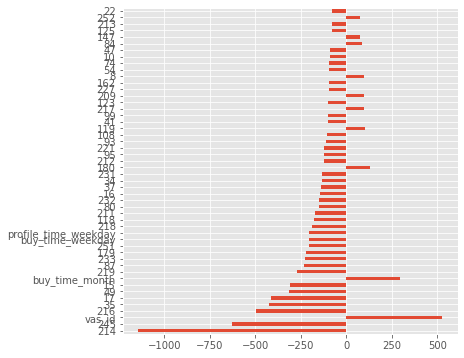

In [422]:
fi_lr, fi_lr_mt_0_cols = extract_features_scores(model=lr_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='lr', cvscore=0.47)

In [423]:
fi_lr

,score
214,-1145.285034
245,-628.175293
vas_id,528.641296
216,-496.024292
35,-426.639404
...,...
68,2.115047
156,1.185872
154,0.175249
246,0.123438


In [424]:
print(len(fi_lr_mt_0_cols), fi_lr_mt_0_cols)

255 ['214', '245', 'vas_id', '216', '35', '17', '49', '15', 'buy_time_month', '219', '87', '233', '179', '251', 'buy_time_weekday', 'profile_time_weekday', '218', '118', '211', '80', '232', '16', '37', '34', '231', '180', '212', '95', '221', '93', '108', '119', '41', '99', '217', '123', '209', '227', '162', '8', '54', '74', '10', '47', '84', '147', '125', '213', '252', '22', '121', 'buy_time_week', '155', '9', '185', '174', '178', '52', '59', '19', '31', '176', '193', '250', '120', '143', 'profile_time_week', '20', '226', '235', '86', '199', '169', '142', '228', '198', '122', '1', '171', '82', '12', '225', '173', '28', '137', '165', '129', '21', '48', '104', '3', '184', '163', '83', '98', '175', '161', '78', '32', '238', '33', '117', '210', '191', '18', '130', '181', '157', '105', '29', '190', '53', '136', '223', '14', '91', '150', '166', '188', '160', '63', '73', '197', '25', '183', '205', '145', '96', '100', '141', '215', '172', '146', '46', '71', '164', '152', '247', '195', '201', '

### LightGBM

In [425]:
import lightgbm
from lightgbm import LGBMClassifier

lgbm: f1_macro = 0.5496 (+/- 0.0177)
features with non 0 importance: (209, 1)


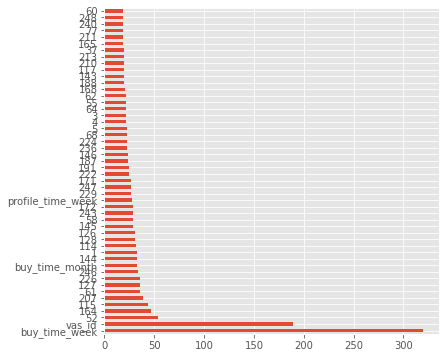

In [426]:
lgbm_ppl = make_pipeline(
    prep_simple,     
    LGBMClassifier(iterations=100, n_jobs=-1, class_weight=class_balance, verbose=0, metric="f1_macro") 
)
fe_lgbm, fe_lgbm_mt_cols = extract_features_scores(model=lgbm_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='lgbm')

In [427]:
fe_lgbm

,score
buy_time_week,320
vas_id,189
52,54
164,47
115,44
...,...
131,0
16,0
95,0
155,0


In [428]:
print(len(fe_lgbm_mt_cols), fe_lgbm_mt_cols)

209 ['buy_time_week', 'vas_id', '52', '164', '115', '207', '61', '127', '226', '246', 'buy_time_month', '144', '1', '114', '128', '126', '145', '58', '243', '172', 'profile_time_week', '229', '247', '171', '222', '191', '187', '146', '236', '224', '68', '5', '4', '3', '64', '55', '62', '168', '188', '143', '117', '210', '213', '37', '165', '211', '77', '240', '248', '60', '53', '238', '51', '7', '245', '193', '0', '230', '244', '59', '130', '208', '250', '134', '227', '186', '148', '63', '49', '2', '241', '111', '47', '129', '20', '223', '44', '150', '40', '166', '112', '103', '9', '116', '225', '106', '237', '182', '110', '151', '50', '167', '228', '249', '136', '158', '185', '239', '73', '242', '159', '13', '108', '169', '233', '34', '251', '56', '147', '43', '234', '140', '135', '12', '96', '76', '174', '138', '36', '137', '10', '66', '91', '107', '194', '142', '162', '100', '235', '104', '21', '160', '195', '183', '102', '19', '48', '46', '74', '54', '156', '119', '25', '97', '30',

### CatBoost

cb: f1_macro = 0.7426 (+/- 0.0038)
features with non 0 importance: (183, 1)


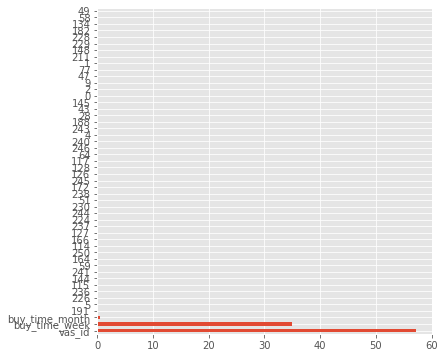

In [429]:
cb_ppl = make_pipeline(
      prep_simple,  
      CatBoostClassifier(iterations=100, thread_count=8, class_weights=class_weights, silent=True, train_dir=training_dir, eval_metric="F1") 
)
fi_cb, fi_cb_mt_cols = extract_features_scores(model=cb_ppl, data=X_train, target=y_train, column_names=f_base_with_dates_extracted, model_type='cb', cvtreshold=None, cvscore=None)

In [430]:
fi_cb

,score
vas_id,57.269904
buy_time_week,34.889651
buy_time_month,0.506586
191,0.187017
5,0.175471
...,...
173,0.000000
41,0.000000
159,0.000000
199,0.000000


In [431]:
print(len(fi_cb_mt_cols), fi_cb_mt_cols)

183 ['vas_id', 'buy_time_week', 'buy_time_month', '191', '5', '226', '236', '115', '144', '241', '59', '164', '250', '114', '166', '127', '237', '224', '244', '230', '51', '238', '172', '245', '126', '128', '117', '64', '246', '240', '4', '243', '188', '28', '43', '145', '0', '2', '9', '47', '77', '1', '211', '148', '229', '228', '182', '134', '58', '49', '62', '52', '48', '213', '249', '3', '53', '50', '66', '157', '217', '39', '25', '248', '193', '44', '171', '239', '146', '247', '60', '208', '129', '251', '63', '61', '106', '110', '135', '7', '133', '20', '37', '68', '70', '104', '76', '105', '56', '161', '8', '136', '234', '207', '168', '215', '227', '143', '54', '69', '34', '45', '107', '225', '38', '103', '19', '156', '111', '169', '158', '140', 'profile_time_month', '40', '141', '97', '73', '55', 'profile_time_week', '184', '108', '71', '96', '142', '201', '113', '222', '72', '30', '183', '204', '137', '223', '185', '170', '231', '153', '162', '132', '42', '21', '112', '233', '1

# Сравнение моделей

In [443]:
# Baseline Logistic Regression
lr_ppl.fit(X_train, y_train)
lr_ppl_pred = lr_ppl.predict_proba(X_test)[:,1]

In [444]:
print(classification_report(y_test, lr_ppl_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    185816
         1.0       0.17      0.00      0.00     18546

    accuracy                           0.91    204362
   macro avg       0.54      0.50      0.48    204362
weighted avg       0.84      0.91      0.87    204362



In [445]:
# LGBM
lgbm_ppl.fit(X_train, y_train)
lgbm_ppl_pred = lgbm_ppl.predict_proba(X_test)[:,1]
print(classification_report(y_test, lgbm_ppl_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    185816
         1.0       0.82      0.07      0.12     18546

    accuracy                           0.91    204362
   macro avg       0.87      0.53      0.54    204362
weighted avg       0.91      0.91      0.88    204362



In [446]:
# Catboost
cb_ppl.fit(X_train, y_train)
cb_ppl_pred = cb_ppl.predict_proba(X_test)[:,1]
print(classification_report(y_test, cb_ppl_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    185816
         1.0       0.40      0.93      0.56     18546

    accuracy                           0.87    204362
   macro avg       0.69      0.89      0.74    204362
weighted avg       0.94      0.87      0.89    204362



Baseline: AUC_PR = 0.142
Baseline: AUC_ROC = 0.501
lgbm_ppl_pred: AUC_PR = 0.561
lgbm_ppl_pred: AUC_ROC = 0.935
cb_ppl_pred: AUC_PR = 0.572
cb_ppl_pred: AUC_ROC = 0.935


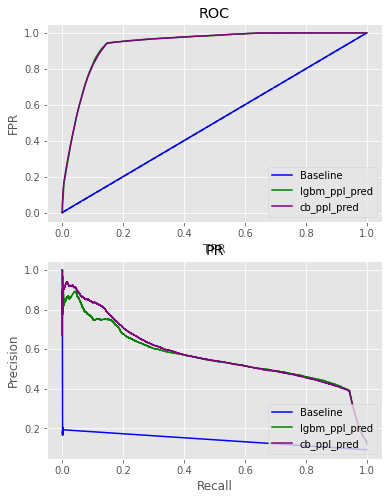

In [454]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(8)
f.set_figwidth(6)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, lr_ppl_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lr_ppl_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, lgbm_ppl_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lgbm_ppl_pred)
ax1.plot(fpr, tpr, label="lgbm_ppl_pred", color='g')
ax2.plot(recall, precision, label="lgbm_ppl_pred", color='g')
print("lgbm_ppl_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lgbm_ppl_pred: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, cb_ppl_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, cb_ppl_pred)
ax1.plot(fpr, tpr, label="cb_ppl_pred", color='purple')
ax2.plot(recall, precision, label="cb_ppl_pred", color='purple')
print("cb_ppl_pred: AUC_PR = %.3f" % auc(recall, precision))
print("cb_ppl_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

# PCA анализ вещественных отобранных признаков 

Посмотрим как можно уменьшить количество вещественных признаков

In [237]:
f_selected_numeric = list(set(lists_diff(fi_cb_mt_cols+fe_lgbm_mt_cols+fi_lr_mt_0_cols, f_num_binary+f_num_3_10+f_dates_extracted)))
print(len(f_selected_numeric), f_selected_numeric)

218 ['145', '42', '178', '162', '104', '115', '82', '93', '87', '124', '157', '228', '189', '63', '21', '102', '61', '252', '161', '79', '118', '160', '146', '250', '96', '165', '242', '8', '213', '25', '92', '128', '112', '14', '179', '130', '141', '135', '246', '1', '90', '114', '69', '247', '59', '208', '22', '50', '121', '229', '211', '235', '80', '184', '110', '238', '98', '100', '73', '219', '185', '77', '207', '40', '62', '49', '123', '46', '55', '245', '107', '126', '125', '231', '177', '12', '140', '186', '4', '66', '105', '10', '176', '168', '108', '122', '20', '153', '58', '60', '109', '72', '134', '187', '223', '232', '137', '148', '99', '183', '19', '76', '48', '3', '144', '221', '175', '94', '173', '169', '174', '28', '244', '191', '111', '0', '39', '41', '159', '51', '136', '152', '239', '133', '248', '45', '230', '16', '2', '234', '119', '167', '142', '164', '5', '113', '6', '156', 'vas_id', '34', '215', '224', '101', '64', '17', '212', '88', '68', '83', '37', '217', '1

In [19]:
def pca_cumulative(cols):
  ss = StandardScaler()
  train_scaled = ss.fit_transform(X_train[cols])
  _pca = PCA().fit(train_scaled)
  plt.plot(_pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
  plt.title(f'Cumulative explained variance by number of principal components of {len(cols)} features', size=20)
  plt.show()
  return _pca

def pca_loadings(tpca, cols):
  _loadings = pd.DataFrame(
    data= tpca.components_.T * np.sqrt( tpca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(cols) + 1)],
    index=cols
  )
  print(_loadings.head())
  return _loadings

def show_pca_component(comp, _loadings): #'PC110'
  _pc_loadings = _loadings.sort_values(by=comp, ascending=False)[[comp]]
  _pc_loadings = _pc_loadings.reset_index()
  _pc_loadings.columns = ['Attribute', f'CorrelationWith{comp}']

  plt.bar(x=_pc_loadings['Attribute'], height=_pc_loadings[f'CorrelationWith{comp}'], color='#087E8B')
  plt.title(f'PCA loading scores ({comp} principal component)', size=12)
  plt.xticks(rotation='vertical')
  plt.show()
  return _pc_loadings

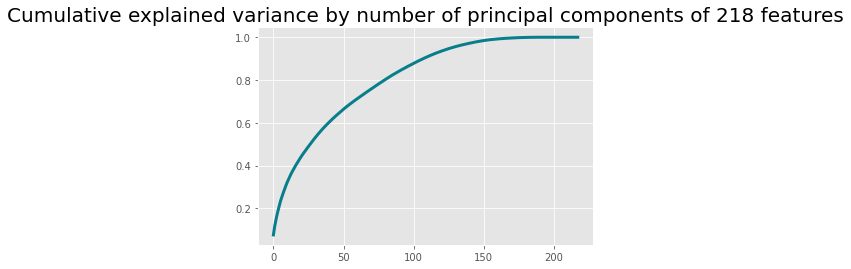

In [242]:
pca_sel_num = pca_cumulative(f_selected_numeric)

Можно объяснить почти 80% дисперсии в наборе данных f_selected_numeric с помощью первых 50-75 основных компонент

In [243]:
loadings_sel_num = pca_loadings(pca_sel_num, f_selected_numeric)

          PC1       PC2       PC3  ...         PC216         PC217         PC218
145  0.185606 -0.001187 -0.078038  ... -0.000000e+00 -0.000000e+00  0.000000e+00
42  -0.085673  0.118610 -0.046482  ...  9.017207e-14  3.201303e-12  2.366364e-12
178 -0.001335  0.098687  0.131617  ...  2.492733e-14  1.631134e-15 -2.267800e-15
162  0.380718  0.015230  0.129082  ... -5.820655e-13  1.664442e-13  3.172872e-13
104  0.328220  0.047282  0.100531  ... -8.905001e-15  1.486500e-14  1.694695e-15

[5 rows x 218 columns]


визуализируем корреляции между входными функциями и первыми основными компонентами:


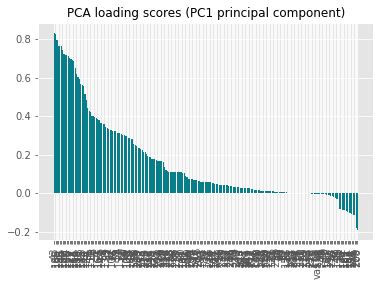

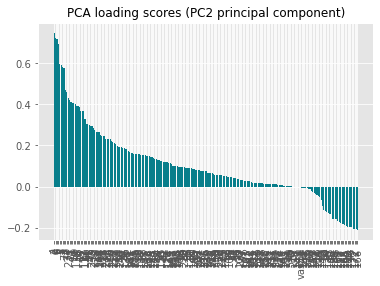

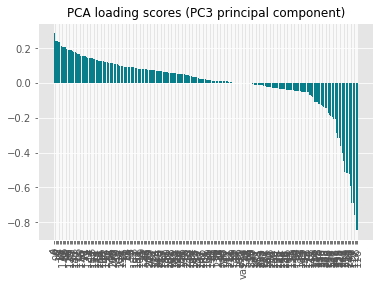

In [402]:
pc1_loadings=show_pca_component('PC1', loadings_sel_num)
pc2_loadings=show_pca_component('PC2', loadings_sel_num)
pc3_loadings=show_pca_component('PC3', loadings_sel_num)

# Визуализируем отобранные признаки и посмотрим на корреляции

In [ ]:
f_viz = list(set(fi_cb_mt_cols+fe_lgbm_mt_cols+fi_lr_mt_0_cols+[f_target]))
print(len(f_viz), f_viz)

164 ['67', '51', '34', '114', '2', 'profile_time', '4', '216', '106', '225', '168', '42', '223', '3', '130', '72', '183', '0', '243', '50', '187', '218', '93', '92', '249', '63', '141', '117', '105', '120', '199', '70', '167', '14', '193', '251', '128', '151', '150', '213', '217', '43', '49', '13', '124', '171', '219', '52', '115', '247', '242', '234', '15', '220', '165', '113', '245', '20', '240', 'buy_time', '241', '64', '108', '55', '62', '173', '224', '208', '244', '97', '82', '125', '211', '98', '100', '109', '54', '227', '190', '107', '1', '246', '41', '222', '226', '207', '59', '24', '36', '96', '164', '118', '25', '186', 'target', '148', '76', '86', '77', '17', '153', '155', '58', '229', '10', '95', 'vas_id', '5', '91', '33', '112', '238', '129', '61', '209', '126', '185', '60', '111', '136', '237', '146', '163', '123', '191', '35', '12', '144', '11', '39', '174', '158', '179', '172', '201', '122', '143', '250', '233', '230', '154', '37', '228', '16', '239', '110', '188', '84',

In [ ]:
analyze_selected = sv.analyze(source=[train_sweet[f_viz], 'Train'], target_feat=f_target, pairwise_analysis = 'on')

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
analyze_selected.show_html(filepath=f"{DATA_PATH}sweet_output/selected_14feb.html")

Report /gdrive/My Drive/Megafon/sweet_output/selected_14feb.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Train model with selected features 

т.к. время разное в наборах данных, заменим его на векторi из других признаков 

см. /sweet_output/selected_14feb.html

In [20]:
buy_time_v_bin = ['216', '33', '201', '199']
buy_time_v_3_10 = ['24', '218', '15', '95', '154']
buy_time_v_num = ['191','59','58','222','158','128','67','148','126','224','25','1','127']

соединим все признаки в 1 список, отберем n первых, и пропустим их через базовый фильтр

141 ['145', '178', '93', '87', '115', '162', '157', '228', '63', '61', '118', '252', '218', '146', '250', '216', '165', '8', '213', '25', '128', '179', '130', '246', '1', '114', '247', '59', '208', '22', '50', '121', '211', '229', '235', '238', '80', '219', '185', '77', '207', '62', '49', '123', '55', '245', '126', '15', '125', '231', '186', '4', '66', '10', '176', '168', '108', '20', '58', '60', '134', '187', '31', '232', '99', '148', '19', '48', '3', '144', '221', '28', '174', '244', '191', '39', '0', '41', 'buy_time_week', '51', 'buy_time_weekday', 'profile_time_weekday', '239', '248', '155', '95', '230', '16', '2', '119', '164', '5', 'vas_id', '34', '224', '64', '17', '212', '68', '217', '37', 'profile_time_week', '222', '227', 'buy_time_month', '44', '54', '251', '171', '172', '226', '180', '117', '127', '193', '210', '241', '166', '84', '52', '47', '249', '243', '209', '147', '35', '7', '43', '233', '53', '120', '236', '9', '188', '214', '143', '237', '74', '86', '240', '182']
da

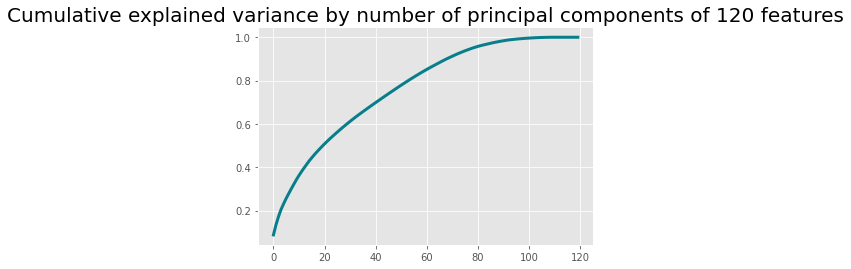

comps47: f1_macro = 0.7479 (+/- 0.0018)


In [480]:
first_n = 140 # n first vars from cb only
pca_comps = 47
_selected= get_n_first_fets(first_n, [fi_cb_mt_cols])  #, fe_lgbm_mt_cols, fi_lr_mt_0_cols
# _selected= get_n_first_fets(first_n, [fi_cb_mt_cols, fe_lgbm_mt_cols, fi_lr_mt_0_cols])
_selected = lists_diff(_selected, f_dates_extracted)
_floats, _num_binary, _num_3_10, _num_10_20, _cat, _objs, _ints, _itimes, _bools = columns_by_dtypes_freq(ds=X_train[_selected], _droplist=[])
print("buy_time_v_bin", buy_time_v_bin)
print("buy_time_v_num", buy_time_v_num)
print("buy_time_v_3_10", buy_time_v_3_10)
_num_rest = lists_diff(_floats, _itimes+buy_time_v_bin+buy_time_v_num+buy_time_v_3_10+f_dates_extracted)
print(len(_num_rest), _num_rest)
pca_cumulative(_num_rest)

base_prep = make_column_transformer(   
    (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler(), PCA(n_components=pca_comps)), lists_diff(_num_rest,f_dates_extracted)),
    (make_pipeline(SimpleImputer(strategy="most_frequent")), f_service),
    # buy time vectors
    (make_pipeline(SimpleImputer(strategy="median")), buy_time_v_num),
    (make_pipeline(SimpleImputer(strategy="most_frequent"), Binarizer(threshold=0)), buy_time_v_bin),  
    (make_pipeline(SimpleImputer(strategy="most_frequent"), StandardScaler(), PCA(n_components=1)), buy_time_v_3_10), 
    #  rest of binaries
    (make_pipeline(SimpleImputer(strategy="most_frequent"), Binarizer(threshold=0)),  lists_diff(_num_binary,buy_time_v_bin)), 
    # times interprtable data
    (make_pipeline(DateExtractor(columns=f_itimes)), f_itimes),
remainder="drop")

cb_final_all = make_pipeline(base_prep, CatBoostClassifier(iterations=100, thread_count=8, class_weights=class_weights, silent=True, train_dir=training_dir, eval_metric="F1"))
mcv = run_cv(estimator=cb_final_all, cv=kfold_cv_stra, _X=X_train, _y=y_train, scoring='f1_macro', model_name=f"comps{pca_comps} {first_n}")

Есть небольшое улучшение по сравнению с базовой предобработкой, + количество переменных уменьшилось, соответственно время обучения и время отклика

подберем гипер параметры для модели

In [23]:
cb_final_arlystop = make_pipeline(
    base_prep, 
    CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.1, max_leaves=31, thread_count=8, class_weights=class_weights, silent=True, early_stopping_rounds=10, train_dir=training_dir, eval_metric="F1"))

In [505]:
[k for k in cb_final_arlystop.get_params().keys() if 'catboost' in k]

['catboostclassifier',
 'catboostclassifier__iterations',
 'catboostclassifier__learning_rate',
 'catboostclassifier__depth',
 'catboostclassifier__thread_count',
 'catboostclassifier__silent',
 'catboostclassifier__class_weights',
 'catboostclassifier__train_dir',
 'catboostclassifier__eval_metric',
 'catboostclassifier__early_stopping_rounds',
 'catboostclassifier__max_leaves']

In [ ]:
[k for k in cb_final_arlystop.get_params().keys() if 'pip' in k]

In [504]:
param_grid = {  "catboostclassifier__depth": [3, 9] }
cb_gsc = run_grid_search(cb_final_arlystop, X_train, y_train, param_grid, kfold_cv_stra)

Best f1_macro score: 0.75

Best parameters set found on development set:

{'catboostclassifier__depth': 9}

Grid scores on development set:

0.743 (+/-0.004) for {'catboostclassifier__depth': 3}
0.746 (+/-0.001) for {'catboostclassifier__depth': 9}



In [509]:
param_grid = {  "catboostclassifier__iterations": [500, 1000] }
cb_gsc = run_grid_search(cb_final_arlystop, X_train, y_train, param_grid, kfold_cv_stra)

Best f1_macro score: 0.75

Best parameters set found on development set:

{'catboostclassifier__iterations': 1000}

Grid scores on development set:

0.754 (+/-0.003) for {'catboostclassifier__iterations': 500}
0.755 (+/-0.003) for {'catboostclassifier__iterations': 1000}



In [511]:
param_grid = { 'columntransformer__pipeline-1__pca__n_components': [20, 30, 40,  50, 60, 70, 80 ] }
cb_gsc = run_grid_search(cb_final_arlystop, X_train, y_train, param_grid, kfold_cv_stra)

Best f1_macro score: 0.76

Best parameters set found on development set:

{'columntransformer__pipeline-1__pca__n_components': 50}

Grid scores on development set:

0.755 (+/-0.005) for {'columntransformer__pipeline-1__pca__n_components': 20}
0.750 (+/-0.005) for {'columntransformer__pipeline-1__pca__n_components': 30}
0.756 (+/-0.004) for {'columntransformer__pipeline-1__pca__n_components': 40}
0.756 (+/-0.002) for {'columntransformer__pipeline-1__pca__n_components': 50}
0.754 (+/-0.004) for {'columntransformer__pipeline-1__pca__n_components': 60}
0.755 (+/-0.004) for {'columntransformer__pipeline-1__pca__n_components': 70}
0.752 (+/-0.003) for {'columntransformer__pipeline-1__pca__n_components': 80}



# Финальная модель

In [25]:
model = cb_gsc.best_estimator_
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=50))]),
                                                  ['245', '243', '169', '213',
                                                   '4', '138', '96', '225',
                                                   '157', '51', '134', '40',
                                                   '100', '104', '161', '76',
                                                   '172', '0', '115', '146',
     

In [26]:
model.fit(X_train, y_train)
model_y_pred = model.predict_proba(X_test)[:,1]

In [27]:
print_score(y_test, model_y_pred)
print(classification_report(y_test, model_y_pred > 0.5))

[0.7314240052788819, 0.7422912579238272, 0.7476949417499186, 0.7521737738860834, 0.7553451126758206, 0.7548123040686485, 0.7455759852849918, 0.7152735736855638, 0.6381533439427222, 0.47623526637773944]
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    185817
         1.0       0.45      0.79      0.57     18545

    accuracy                           0.89    204362
   macro avg       0.71      0.85      0.76    204362
weighted avg       0.93      0.89      0.91    204362



# save model / answers_test.csv

In [28]:
import pickle
from datetime import date

#----To store model----------
filename = f"{DATA_PATH}model{str(date.today())}"
pickle.dump(model, open(filename, 'wb')) 
print(filename)

/gdrive/My Drive/Megafon/model2022-02-15


In [29]:
# data_test_pre_saved
data_test = load_file(f"{DATA_PATH}{test_fname}")
print(data_test.shape)
print(data_test.info())

loaded (69535, 263) from /gdrive/My Drive/Megafon/data_test_buy_time_id_True_backward
(69535, 263)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69535 entries, 0 to 69534
Columns: 263 entries, Unnamed: 0 to dprofile_time
dtypes: float64(257), int64(4), object(2)
memory usage: 139.5+ MB
None


In [30]:
data_test_template = load_file(f"{DATA_PATH}data_test")
print(data_test_template.shape)
print(data_test_template.info())

loaded (71231, 4) from /gdrive/My Drive/Megafon/data_test
(71231, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB
None


In [31]:
loaded_model = pickle.load(open(filename, 'rb'))
testdata_pred = loaded_model.predict_proba(data_test)[:,1]
testdata_pred.shape, testdata_pred

((69535,),
 array([0.00209599, 0.00392592, 0.18369719, ..., 0.00364815, 0.22469362,
        0.00637518]))

In [32]:
data_test['target'] = testdata_pred

In [33]:
data_test

,Unnamed: 0,Unnamed: 0_x,id,vas_id,buy_time,Unnamed: 0_y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,profile_time,profile_id,dbuy_time,dprofile_time,target
0,0,35615,2905850,5.0,1546808400,1376697.0,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,357.540873,346.21189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,9.643757e+08,365.185922,-4.405604e+08,-1.204418e+08,-8.900668,-1.465191,-33.302382,-208.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,894.30898,-1.368281,-157.110707,-41.409742,1097.562669,-87.617978,-17.295406,-464.373846,-104.770792,-25.996269,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0,1.536527e+09,2905850.0,2019-01-06 21:00:00,2018-09-09 21:00:00,0.002096
1,1,22425,31619,2.0,1546808400,1344228.0,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,34.759185,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,9.643757e+08,-53.464078,1.041311e+09,-1.204418e+08,13.099332,-1.465191,-33.302382,-266.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-106.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1.536527e+09,31619.0,2019-01-06 21:00:00,2018-09-09 21:00:00,0.003926
2,2,46257,1427271,6.0,1546808400,2306172.0,-87.299971,-368.999112,339.439214,48.733202,334.021754,27.62821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-56.689127,-68.01811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,426.739185,380.115836,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,1.648138,1.785634,0.788392,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,9.609197e+08,-53.794078,-4.405604e+08,-1.204418e+08,8.565998,-1.465191,-33.302382,395.871014,-18.772492,-0.364694,-0.133771,-0.209468,-14.356505,-109.884564,328.30898,-1.368281,945.889293,-108.409742,-507.437331,104.382022,-17.295406,928.626154,-548.770792,0.003731,-37.630448,116.252276,25.167111,-0.694428,38.824067,-0.45614,0.0,1.533503e+09,1427271.0,2019-01-06 21:00:00,2018-08-05 21:00:00,0.183697
3,3,22421,2162521,6.0,1546808400,650510.0,-96.799971,-20.459112,-110.740786,-34.936798,-116.158246,-56.04179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,...,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,14.149332,-1.465191,-33.302382,-265.128986,-38.772492,-0.364694,-0.133771,-0.209468,-34.356505,-109.884564,-755.69102,-5.368281,-247.110707,-106.409742,-393.437331,-106.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-298.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0,1.533503e+09,2162521.0,2019-01-06 21:00:00,2018-08-05 21:00:00,0.176745
4,4,22420,1529304,6.0,1546808400,2916503.0,-96.799971,-394.439112,-110.740786,-447.046798,-116.158246,-468.15179,-16.08618,-54.636097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733

In [34]:
answers_df = data_test[data_test_template.columns.to_list()+['target']]
answers_df = answers_df.drop(columns=['Unnamed: 0'])

In [35]:
answers_df

,id,vas_id,buy_time,target
0,2905850,5.0,1546808400,0.002096
1,31619,2.0,1546808400,0.003926
2,1427271,6.0,1546808400,0.183697
3,2162521,6.0,1546808400,0.176745
4,1529304,6.0,1546808400,0.020050
...,...,...,...,...
69530,3145392,6.0,1548018000,0.362445
69531,2452188,2.0,1548018000,0.023591
69532,3145390,2.0,1548018000,0.003648
69533,1447357,6.0,1548018000,0.224694


In [36]:
ans_file = f'{DATA_PATH}answers_test.csv'
answers_df.to_csv(ans_file)
print(f"Saved {ans_file} {answers_df.shape}")

Saved /gdrive/My Drive/Megafon/answers_test.csv (69535, 4)
